In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [2]:
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")


In [3]:
data = pd.read_csv("diabetes.csv")

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<function matplotlib.pyplot.show(close=None, block=None)>

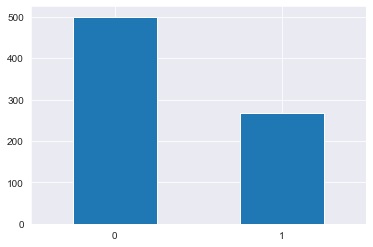

In [5]:
count_of_diabetic = pd.value_counts(data['Outcome'],sort= True)
count_of_diabetic.plot(kind = 'bar',rot = 0)
plt.show

<AxesSubplot:>

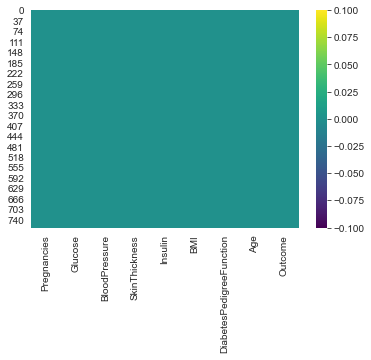

In [6]:
sns.heatmap(data.isnull(), cmap = "viridis")

In [7]:
data.isnull().values.any()

False

In [8]:
if len(data[data.duplicated()])>0:
    print("Num. of duplicate values:{} ".foramt(len(data[data.duplicated()])))
else:
    print("No duplicate values")

No duplicate values


In [9]:
data.shape

(768, 9)

In [10]:
data.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [13]:
print(len(data.loc[data['Glucose']==0]))
print(len(data.loc[data['Insulin']==0]))



5
374


In [14]:
data['Glucose'] = np.where(data['Glucose']==0,data['Glucose'].median(), data['Glucose'])
data['Insulin'] = np.where(data['Insulin']==0,data['Insulin'].median(), data['Insulin'])

In [15]:
X = data.drop('Outcome',axis=1)
y = data['Outcome']

In [27]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72,35,0,33.6,0.627,50
1,1,85.0,66,29,0,26.6,0.351,31
2,8,183.0,64,0,0,23.3,0.672,32
3,1,89.0,66,23,94,28.1,0.167,21
4,0,137.0,40,35,168,43.1,2.288,33


In [16]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [19]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=33)

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier(n_estimators=10).fit(X_train,y_train)
prediction=rf_classifier.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[87 12]
 [29 26]]
0.7337662337662337
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        99
           1       0.68      0.47      0.56        55

    accuracy                           0.73       154
   macro avg       0.72      0.68      0.68       154
weighted avg       0.73      0.73      0.72       154



In [30]:
### Random Hyperparameter Tuning with random values for parameters


model=RandomForestClassifier(n_estimators=300,criterion='entropy',
                             max_features='sqrt',min_samples_leaf=10,random_state=100).fit(X_train,y_train)
predictions=model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[88 11]
 [26 29]]
0.7597402597402597
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        99
           1       0.72      0.53      0.61        55

    accuracy                           0.76       154
   macro avg       0.75      0.71      0.72       154
weighted avg       0.76      0.76      0.75       154



### Automated Hyperparameter Tuning
Automated Hyperparameter Tuning can be done by using techniques such as 
- Bayesian Optimization
- Gradient Descent
- Evolutionary Algorithms

#### Bayesian Optimization
Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which can gives us the lowest possible output value.It usually performs better than random,grid and manual search providing better performance in the testing phase and reduced optimization time.
In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin.

- Objective Function = defines the loss function to minimize.
- Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
- Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.

In [32]:
import hyperopt

In [33]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

In [34]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

In [36]:
space['criterion']

In [37]:
from sklearn.model_selection import cross_val_score

In [38]:

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [39]:
trials = Trials()
best_fn = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best_fn

100%|███████████████████████████████████████████████| 80/80 [08:33<00:00,  6.42s/trial, best loss: -0.7785285885645742]


{'criterion': 1,
 'max_depth': 140.0,
 'max_features': 3,
 'min_samples_leaf': 0.00033304073240011944,
 'min_samples_split': 0.14467105749889794,
 'n_estimators': 4}

In [41]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}


print(crit[best_fn['criterion']])
print(feat[best_fn['max_features']])
print(est[best_fn['n_estimators']])

gini
None
1200


In [44]:
trainedforest = RandomForestClassifier(criterion = crit[best_fn['criterion']], max_depth = best_fn['max_depth'], 
                                       max_features = feat[best_fn['max_features']], 
                                       min_samples_leaf = best_fn['min_samples_leaf'], 
                                       min_samples_split = best_fn['min_samples_split'], 
                                       n_estimators = est[best_fn['n_estimators']]).fit(X_train,y_train)
predictionforest = trainedforest.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(accuracy_score(y_test,predictionforest))
print(classification_report(y_test,predictionforest))

[[87 12]
 [26 29]]
0.7532467532467533
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        99
           1       0.71      0.53      0.60        55

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154



#### Genetic Algorithms
Genetic Algorithms tries to apply natural selection mechanisms to Machine Learning contexts.

Let's immagine we create a population of N Machine Learning models with some predifined Hyperparameters. We can then calculate the accuracy of each model and decide to keep just half of the models (the ones that performs best). We can now generate some offsprings having similar Hyperparameters to the ones of the best models so that go get again a population of N models. At this point we can again caltulate the accuracy of each model and repeate the cycle for a defined number of generations. In this way, just the best models will survive at the end of the process.

In [45]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(param)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [46]:
from tpot import TPOTClassifier

In [51]:
tpot_classifier = TPOTClassifier(generations=5,population_size=24,offspring_size=12,cv=5,verbosity=2,scoring='accuracy',
                              config_dict={'sklearn.ensemble.RandomForestClassifier': param},early_stop=12)

In [52]:
tpot_classifier.fit(X_train,y_train)


Generation 1 - Current best internal CV score: 0.7785419165667067

Generation 2 - Current best internal CV score: 0.7785419165667067

Generation 3 - Current best internal CV score: 0.7785419165667067

Generation 4 - Current best internal CV score: 0.7785552445688391

Generation 5 - Current best internal CV score: 0.7801546048247368

Best pipeline: RandomForestClassifier(RandomForestClassifier(input_matrix, criterion=gini, max_depth=780, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1800), criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [10,
                                                                                      120,
                                                                                      230,
                                                                                      340,
                                                                                      450,
                                                                                      560,
                                                                                      670,
                                                                                      780,
                                                                                 

In [53]:
accuracy = tpot_classifier.score(X_test, y_test)
print(accuracy)

0.7662337662337663
